# Wealth Distribution Dynamics

```{include} _admonition/gpu.md
```

This lecture is the extended JAX implementation of [this lecture](https://python.quantecon.org/wealth_dynamics.html). 

Please refer that lecture for all background and notation.

We will use the following imports.

In [1]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from collections import namedtuple

Let's check the GPU we are running

In [2]:
!nvidia-smi

/opt/conda/envs/quantecon/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Thu Mar  7 02:01:11 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 12.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|


|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   30C    P0    37W / 300W |      0MiB / 16160MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+


## Lorenz Curves and the Gini Coefficient

Before we investigate wealth dynamics, we briefly review some measures of
inequality.

### Lorenz Curves

One popular graphical measure of inequality is the [Lorenz curve](https://en.wikipedia.org/wiki/Lorenz_curve).

To illustrate, let us define a function `lorenz_curve_jax` that returns the cumulative share of people and the cumulative share of income earned.

In [3]:
@jax.jit
def lorenz_curve_jax(y):
    n = y.shape[0]
    y = jnp.sort(y)
    s = jnp.concatenate((jnp.zeros(1), jnp.cumsum(y)))
    _cum_p = jnp.arange(1, n + 1) / n
    cum_income = s / s[n]
    cum_people = jnp.concatenate((jnp.zeros(1), _cum_p))
    return cum_people, cum_income

Let's suppose that

In [4]:
n = 10_000                                              # Size of sample
rand_key = jax.random.PRNGKey(101)                      # Set random key
w = jnp.exp(jax.random.normal(rand_key, shape=(n,)))    # Lognormal draws

is data representing the wealth of 10,000 households.

We can compute and plot the Lorenz curve as follows:

In [5]:
%%time

f_vals, l_vals = lorenz_curve_jax(w)

CPU times: user 746 ms, sys: 17 ms, total: 763 ms
Wall time: 1.07 s


In [6]:
%%time

# This will be much faster as it will use the jitted function
f_vals, l_vals = lorenz_curve_jax(w)

CPU times: user 389 µs, sys: 210 µs, total: 599 µs
Wall time: 259 µs


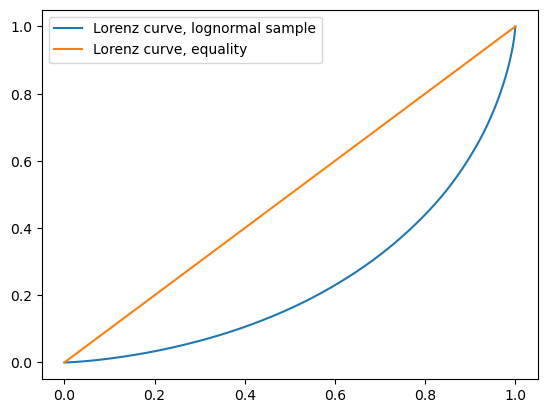

In [7]:
fig, ax = plt.subplots()
ax.plot(f_vals, l_vals, label='Lorenz curve, lognormal sample')
ax.plot(f_vals, f_vals, label='Lorenz curve, equality')
ax.legend()
plt.show()

Here is another example, which shows how the Lorenz curve shifts as the
underlying distribution changes.

We generate 10,000 observations using the Pareto distribution with a range of
parameters, and then compute the Lorenz curve corresponding to each set of
observations.

In [8]:
a_vals = (1, 2, 5)              # Pareto tail index
n = 10_000                      # size of each sample

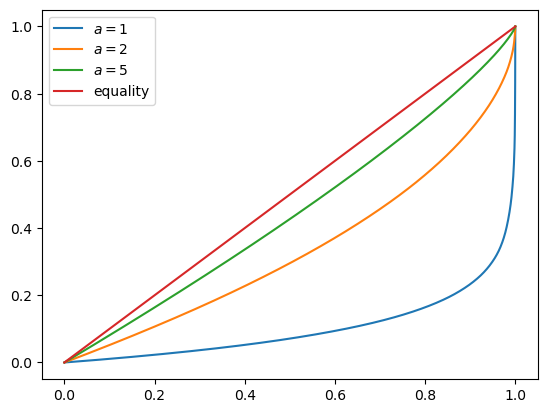

In [9]:
fig, ax = plt.subplots()
for a in a_vals:
    rand_key = jax.random.PRNGKey(a*100)
    u = jax.random.uniform(rand_key, shape=(n,))
    y = u**(-1/a)                    # distributed as Pareto with tail index a
    f_vals, l_vals = lorenz_curve_jax(y)
    ax.plot(f_vals, l_vals, label=f'$a = {a}$')

ax.plot(f_vals, f_vals, label='equality')
ax.legend()
plt.show()

You can see that, as the tail parameter of the Pareto distribution increases, inequality decreases.

This is to be expected, because a higher tail index implies less weight in the tail of the Pareto distribution.

### The Gini Coefficient

The definition and interpretation of the Gini coefficient can be found on the corresponding [Wikipedia page](https://en.wikipedia.org/wiki/Gini_coefficient).

We can test it on the Weibull distribution with parameter $a$, where the Gini coefficient is known to be

$$
G = 1 - 2^{-1/a}
$$

Let's define a function to compute the Gini coefficient.

In [10]:
@jax.jit
def gini_jax(y):
    n = y.shape[0]
    g_sum = 0

    def sum_y_gini(i, g_sum):
        g_sum += jnp.sum(jnp.abs(y[i] - y))
        return g_sum
    
    g_sum = jax.lax.fori_loop(0, n, sum_y_gini, 0)
    return g_sum / (2 * n * jnp.sum(y))

Let's see if the Gini coefficient computed from a simulated sample matches
this at each fixed value of $a$.

In [11]:
a_vals = range(1, 20)
ginis = []
ginis_theoretical = []
n = 100

for a in a_vals:
    rand_key = jax.random.PRNGKey(a)
    y = jax.random.weibull_min(rand_key, 1, a, shape=(n,))
    ginis.append(gini_jax(y))
    ginis_theoretical.append(1 - 2**(-1/a))

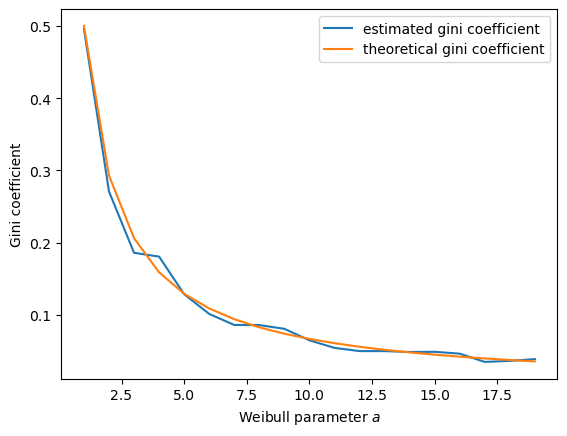

In [12]:
fig, ax = plt.subplots()
ax.plot(a_vals, ginis, label='estimated gini coefficient')
ax.plot(a_vals, ginis_theoretical, label='theoretical gini coefficient')
ax.legend()
ax.set_xlabel("Weibull parameter $a$")
ax.set_ylabel("Gini coefficient")
plt.show()

The simulation shows that the fit is good.

## A Model of Wealth Dynamics

Having discussed inequality measures, let us now turn to wealth dynamics.

The model we will study is

```{math}
:label: wealth_dynam_ah

w_{t+1} = (1 + r_{t+1}) s(w_t) + y_{t+1}
```

where

- $w_t$ is wealth at time $t$ for a given household,
- $r_t$ is the rate of return of financial assets,
- $y_t$ is current non-financial (e.g., labor) income and
- $s(w_t)$ is current wealth net of consumption

## Implementation using JAX

Let's define a model to represent the wealth dynamics.

In [13]:
# NamedTuple Model

Model = namedtuple("Model", ("w_hat", "s_0", "c_y", "μ_y",
                             "σ_y", "c_r", "μ_r", "σ_r", "a",
                             "b", "σ_z", "z_mean", "z_var", "y_mean"))

Here's a function to create the Model with the given parameters

In [14]:
def create_wealth_model(w_hat=1.0,
                        s_0=0.75,
                        c_y=1.0,
                        μ_y=1.0,
                        σ_y=0.2,
                        c_r=0.05,
                        μ_r=0.1,
                        σ_r=0.5,
                        a=0.5,
                        b=0.0,
                        σ_z=0.1):
    """
    Create a wealth model with given parameters and return
    and instance of NamedTuple Model.
    """
    z_mean = b / (1 - a)
    z_var = σ_z**2 / (1 - a**2)
    exp_z_mean = jnp.exp(z_mean + z_var / 2)
    R_mean = c_r * exp_z_mean + jnp.exp(μ_r + σ_r**2 / 2)
    y_mean = c_y * exp_z_mean + jnp.exp(μ_y + σ_y**2 / 2)
    # Test a stability condition that ensures wealth does not diverge
    # to infinity.
    α = R_mean * s_0
    if α >= 1:
        raise ValueError("Stability condition failed.")
    return Model(w_hat=w_hat, s_0=s_0, c_y=c_y, μ_y=μ_y,
                 σ_y=σ_y, c_r=c_r, μ_r=μ_r, σ_r=σ_r, a=a,
                 b=b, σ_z=σ_z, z_mean=z_mean, z_var=z_var, y_mean=y_mean)

The following function updates one period with the given current wealth and persistent state.

In [15]:
def update_states_jax(arrays, wdy, size, rand_key):
    """
    Update one period, given current wealth w and persistent
    state z. They are stored in the form of tuples under the arrays argument
    """
    # Unpack w and z
    w, z = arrays

    rand_key, *subkey = jax.random.split(rand_key, 3)
    zp = wdy.a * z + wdy.b + wdy.σ_z * jax.random.normal(rand_key, shape=size)

    # Update wealth
    y = wdy.c_y * jnp.exp(zp) + jnp.exp(
                        wdy.μ_y + wdy.σ_y * jax.random.normal(subkey[0], shape=size))
    wp = y

    R = wdy.c_r * jnp.exp(zp) + jnp.exp(
                        wdy.μ_r + wdy.σ_r * jax.random.normal(subkey[1], shape=size))
    wp += (w >= wdy.w_hat) * R * wdy.s_0 * w
    return wp, zp

Here’s function to simulate the time series of wealth for individual households using a `for` loop and JAX.

In [16]:
# Using JAX and for loop

def wealth_time_series_for_loop_jax(w_0, n, wdy, size, rand_seed=1):
    """
    Generate a single time series of length n for wealth given
    initial value w_0.

    * This implementation uses a `for` loop.

    The initial persistent state z_0 for each household is drawn from
    the stationary distribution of the AR(1) process.

        * wdy: NamedTuple Model
        * w_0: scalar/vector
        * n: int
        * size: size/shape of the w_0
        * rand_seed: int (Used to generate PRNG key)
    """
    rand_key = jax.random.PRNGKey(rand_seed)
    rand_key, *subkey = jax.random.split(rand_key, n)

    w_0 = jax.device_put(w_0).reshape(size)

    z = wdy.z_mean + jnp.sqrt(wdy.z_var) * jax.random.normal(rand_key, shape=size)
    w = [w_0]
    for t in range(n-1):
        w_, z = update_states_jax((w[t], z), wdy, size, subkey[t])
        w.append(w_)
    return jnp.array(w)

Let's try simulating the model at different parameter values and investigate the implications for the wealth distribution using the above function.

In [17]:
wdy = create_wealth_model() # default model
ts_length = 200
size = (1,)

In [18]:
%%time

w_jax_result = wealth_time_series_for_loop_jax(wdy.y_mean,
                                               ts_length, wdy, size).block_until_ready()

CPU times: user 2.1 s, sys: 404 ms, total: 2.5 s
Wall time: 1.69 s


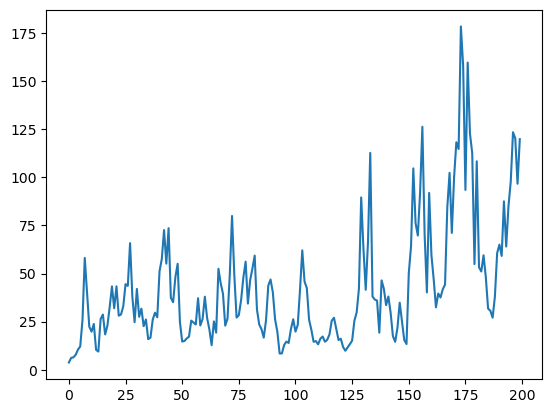

In [19]:
fig, ax = plt.subplots()
ax.plot(w_jax_result)
plt.show()

We can further try to optimize and speed up the compile time of the above function by replacing `for` loop with [`jax.lax.scan`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html).

In [20]:
def wealth_time_series_jax(w_0, n, wdy, size, rand_seed=1):
    """
    Generate a single time series of length n for wealth given
    initial value w_0.

    * This implementation uses `jax.lax.scan`.

    The initial persistent state z_0 for each household is drawn from
    the stationary distribution of the AR(1) process.

        * wdy: NamedTuple Model
        * w_0: scalar/vector
        * n: int
        * size: size/shape of the w_0
        * rand_seed: int (Used to generate PRNG key)
    """
    rand_key = jax.random.PRNGKey(rand_seed)
    rand_key, *subkey = jax.random.split(rand_key, n)

    w_0 = jax.device_put(w_0).reshape(size)
    z_init = wdy.z_mean + jnp.sqrt(wdy.z_var) * jax.random.normal(rand_key, shape=size)
    arrays = w_0, z_init
    rand_sub_keys = jnp.array(subkey)

    w_final = jnp.array([w_0])

    # Define the function for each update
    def update_w_z(arrays, rand_sub_key):
        wp, zp = update_states_jax(arrays, wdy, size, rand_sub_key)
        return (wp, zp), wp

    arrays_last, w_values = jax.lax.scan(update_w_z, arrays, rand_sub_keys)
    return jnp.concatenate((w_final, w_values))

# Create the jit function
wealth_time_series_jax = jax.jit(wealth_time_series_jax, static_argnums=(1,3,))

Let's try simulating the model at different parameter values and investigate the implications for the wealth distribution and also observe the difference in time between `wealth_time_series_jax` and `wealth_time_series_for_loop_jax`.

In [21]:
wdy = create_wealth_model() # default model
ts_length = 200
size = (1,)

In [22]:
%%time

w_jax_result = wealth_time_series_jax(wdy.y_mean, ts_length, wdy, size).block_until_ready()

CPU times: user 652 ms, sys: 7.12 ms, total: 659 ms
Wall time: 513 ms


Running the above function again will be even faster because of JAX's JIT.

In [23]:
%%time

# 2nd time is expected to be very fast because of JIT
w_jax_result = wealth_time_series_jax(wdy.y_mean, ts_length, wdy, size).block_until_ready()

CPU times: user 10.5 ms, sys: 1.51 ms, total: 12 ms
Wall time: 7.59 ms


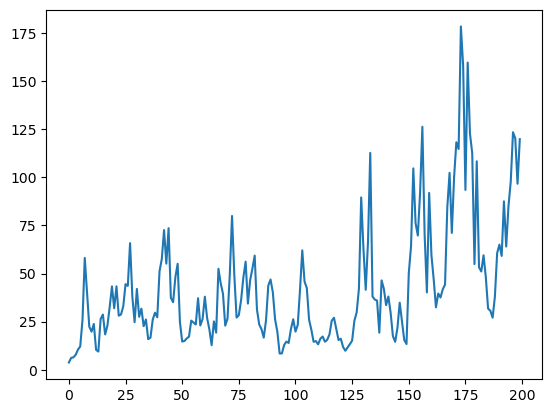

In [24]:
fig, ax = plt.subplots()
ax.plot(w_jax_result)
plt.show()

Now here’s function to simulate a cross section of households forward in time.

In [25]:
def update_cross_section_jax(w_distribution, shift_length, wdy, size, rand_seed=2):
    """
    Shifts a cross-section of household forward in time

    * wdy: NamedTuple Model
    * w_distribution: array_like, represents current cross-section

    Takes a current distribution of wealth values as w_distribution
    and updates each w_t in w_distribution to w_{t+j}, where
    j = shift_length.

    Returns the new distribution.
    """
    new_dist = wealth_time_series_jax(w_distribution, shift_length, wdy, size, rand_seed)
    new_distribution = new_dist[-1, :]
    return new_distribution


# Create the jit function
update_cross_section_jax = jax.jit(update_cross_section_jax, static_argnums=(1,3,))

## Applications

Let's try simulating the model at different parameter values and investigate
the implications for the wealth distribution.


### Inequality Measures

Let's look at how inequality varies with returns on financial assets.

The next function generates a cross section and then computes the Lorenz
curve and Gini coefficient.

In [26]:
def generate_lorenz_and_gini_jax(wdy, num_households=100_000, T=500):
    """
    Generate the Lorenz curve data and gini coefficient corresponding to a
    WealthDynamics mode by simulating num_households forward to time T.
    """
    size = (num_households, )
    ψ_0 = jnp.full(size, wdy.y_mean)
    ψ_star = update_cross_section_jax(ψ_0, T, wdy, size)
    return gini_jax(ψ_star), lorenz_curve_jax(ψ_star)

# Create the jit function
generate_lorenz_and_gini_jax = jax.jit(generate_lorenz_and_gini_jax,
                                       static_argnums=(1,2,))

Now we investigate how the Lorenz curves associated with the wealth distribution change as return to savings varies.

The code below plots Lorenz curves for three different values of $\mu_r$.

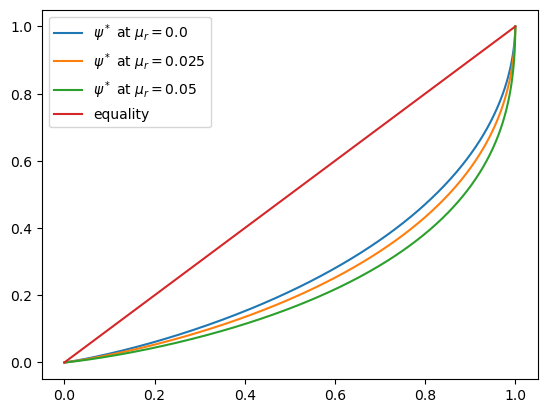

CPU times: user 5.32 s, sys: 0 ns, total: 5.32 s
Wall time: 5.42 s


In [27]:
%%time

fig, ax = plt.subplots()
μ_r_vals = (0.0, 0.025, 0.05)
gini_vals = []

for μ_r in μ_r_vals:
    wdy = create_wealth_model(μ_r=μ_r)
    gv, (f_vals, l_vals) = generate_lorenz_and_gini_jax(wdy)
    ax.plot(f_vals, l_vals, label=f'$\psi^*$ at $\mu_r = {μ_r:0.2}$')
    gini_vals.append(gv)

ax.plot(f_vals, f_vals, label='equality')
ax.legend(loc="upper left")
plt.show()

The Lorenz curve shifts downwards as returns on financial income rise, indicating a rise in inequality.

Now let's check the Gini coefficient.

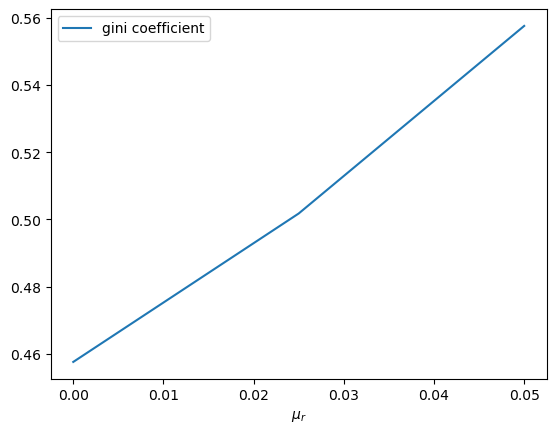

In [28]:
fig, ax = plt.subplots()
ax.plot(μ_r_vals, gini_vals, label='gini coefficient')
ax.set_xlabel("$\mu_r$")
ax.legend()
plt.show()

Once again, we see that inequality increases as returns on financial income
rise.

Let's finish this section by investigating what happens when we change the
volatility term $\sigma_r$ in financial returns.

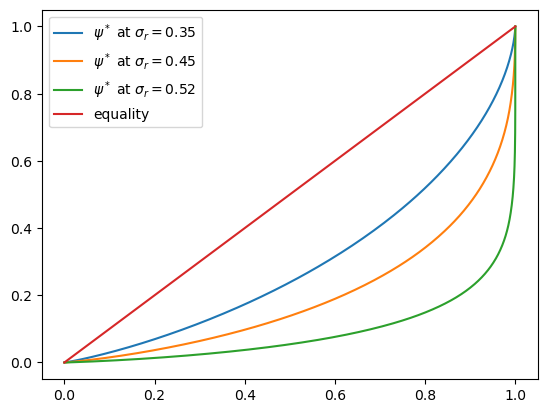

CPU times: user 2.93 s, sys: 0 ns, total: 2.93 s
Wall time: 2.86 s


In [29]:
%%time

fig, ax = plt.subplots()
σ_r_vals = (0.35, 0.45, 0.52)
gini_vals = []

for σ_r in σ_r_vals:
    wdy = create_wealth_model(σ_r=σ_r)
    gv, (f_vals, l_vals) = generate_lorenz_and_gini_jax(wdy)
    ax.plot(f_vals, l_vals, label=f'$\psi^*$ at $\sigma_r = {σ_r:0.2}$')
    gini_vals.append(gv)

ax.plot(f_vals, f_vals, label='equality')
ax.legend(loc="upper left")
plt.show()

We see that greater volatility has the effect of increasing inequality in this model.

## Exercises

```{exercise}
:label: wd_ex1

For a wealth or income distribution with Pareto tail, a higher tail index suggests lower inequality.

Indeed, it is possible to prove that the Gini coefficient of the Pareto
distribution with tail index $a$ is $1/(2a - 1)$.

To the extent that you can, confirm this by simulation.

In particular, generate a plot of the Gini coefficient against the tail index
using both the theoretical value just given and the value computed from a sample via `gini_jax`.

For the values of the tail index, use `a_vals = jnp.linspace(1, 10, 25)`.

Use sample of size 1,000 for each $a$ and the sampling method for generating Pareto draws employed in the discussion of Lorenz curves for the Pareto distribution.

To the extent that you can, interpret the monotone relationship between the
Gini index and $a$.
```

```{solution-start} wd_ex1
:class: dropdown
```

Here is one solution, which produces a good match between theory and
simulation.

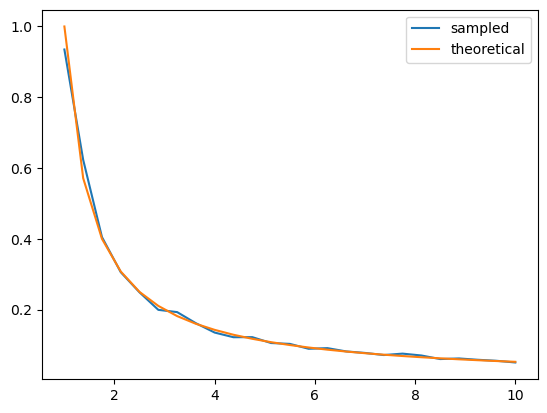

In [30]:
a_vals = jnp.linspace(1, 10, 25)  # Pareto tail index
ginis = []

n = 1000                         # size of each sample
fig, ax = plt.subplots()
for i, a in enumerate(a_vals):
    rand_key = jax.random.PRNGKey(i*10)
    u = jax.random.uniform(rand_key, shape=(n,))
    y = u**(-1/a)
    ginis.append(gini_jax(y))
ax.plot(a_vals, ginis, label='sampled')
ax.plot(a_vals, 1/(2*a_vals - 1), label='theoretical')
ax.legend()
plt.show()

In general, for a Pareto distribution, a higher tail index implies less weight
in the right hand tail.

This means less extreme values for wealth and hence more equality.

More equality translates to a lower Gini index.

```{solution-end}
```

```{exercise-start}
:label: wd_ex2
```

When savings is constant, the wealth process has the same quasi-linear
structure as a Kesten process, with multiplicative and additive shocks.

The Kesten--Goldie theorem tells us that Kesten processes have Pareto tails under a range of parameterizations.

The theorem does not directly apply here, since savings is not always constant and since the multiplicative and additive terms in {eq}`wealth_dynam_ah` are not IID.

At the same time, given the similarities, perhaps Pareto tails will arise.

To test this, run a simulation that generates a cross-section of wealth and
generate a rank-size plot.

In viewing the plot, remember that Pareto tails generate a straight line.  Is
this what you see?

For sample size and initial conditions, use

In [31]:
num_households = 250_000
T = 500 # Shift forward T periods
ψ_0 = jnp.full((num_households, ), wdy.y_mean) # Initial distribution

```{exercise-end}
```

```{solution-start} wd_ex2
:class: dropdown
```

First let's generate the distribution:

In [32]:
num_households = 250_000
T = 500  # how far to shift forward in time
size = (num_households, )

wdy = create_wealth_model()
ψ_0 = jnp.full(size, wdy.y_mean)
ψ_star = update_cross_section_jax(ψ_0, T, wdy, size)

Let's define a function to get the rank data

In [33]:
def rank_size(data, c=1):
    w = -jnp.sort(-data)                  # Reverse sort
    w = w[:int(len(w) * c)]               # extract top (c * 100)%
    rank_data = jnp.arange(len(w)) + 1
    size_data = w
    return rank_data, size_data

Now let's see the rank-size plot:

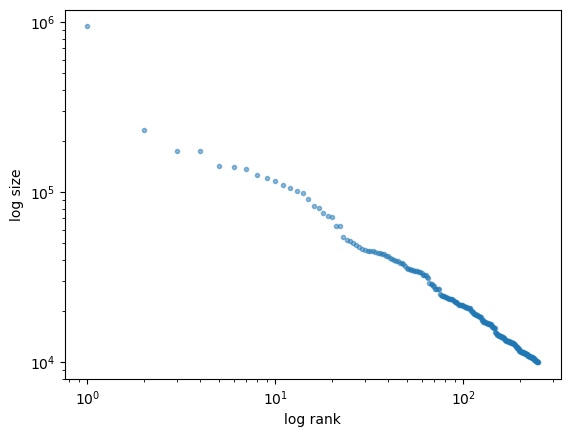

In [34]:
fig, ax = plt.subplots()

rank_data, size_data = rank_size(ψ_star, c=0.001)
ax.loglog(rank_data, size_data, 'o', markersize=3.0, alpha=0.5)
ax.set_xlabel("log rank")
ax.set_ylabel("log size")

plt.show()

```{solution-end}
```